<a href="https://colab.research.google.com/github/HaydeePeruyero/CAMDA2023/blob/main/resultados/Camda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leer OTUS

In [52]:
import contextily as ctx
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [53]:
carpeta_data = "data"
nombre_archivo = "relative_order_assembly.csv"

# Obtén la ruta absoluta de la carpeta actual
ruta_actual = os.getcwd()
# Construye la ruta completa al archivo CSV dentro de la carpeta "data"
ruta_archivo = os.path.join(ruta_actual, carpeta_data, nombre_archivo)
otus = pd.read_csv(ruta_archivo, index_col="ID")

cont_names = list(otus.drop(["ID_city","City","Climate","Latitude", "Longitude","Year"], axis=1).columns)
y_names = ["ID_city"]
otus_df = otus[cont_names+y_names]
otus_df.shape

(365, 288)

In [54]:
y_counts = otus_df.ID_city.value_counts()

y = np.array(otus_df[y_names]).ravel()
#X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
X = otus_df.drop(y_names,axis=1).astype('float')

# Reducción y selección de características.

Se probarán diferentes métodos para seleccionar características relevantes. Los criterios de relevancia son diferentes para cada método.

Se usarán todos los datos como entrenamiento

In [56]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# estandarización de covariables
X_std = StandardScaler().fit_transform(X)
# lo convierto de nuevo a dataframe para conservar los índices de renglones y columnas
X_std = pd.DataFrame(X_std,index=X.index, columns=X.columns)

# categorización de la respuesta
le = LabelEncoder()
le.fit(y)
#le.classes_
y_cat = le.transform(y)
#le.inverse_transform(y_cat[:5])

X_train = X_std
y_train = y_cat

# nombres de las variables
varnames = X_std.columns.tolist()

# NUMERO DE VARIABLES QUE SE VAN A SELECCIONAR EN CADA MÉTODO
n_feat = 100

## Random forests

El criterio para la selección de características, es la reducción del índice de impureza de Gini

In [57]:
from otus_feat import rf_features, rfe_features, get_reduced_df

In [58]:
rf_vars = rf_features(X_train, y_train, num_features=n_feat)

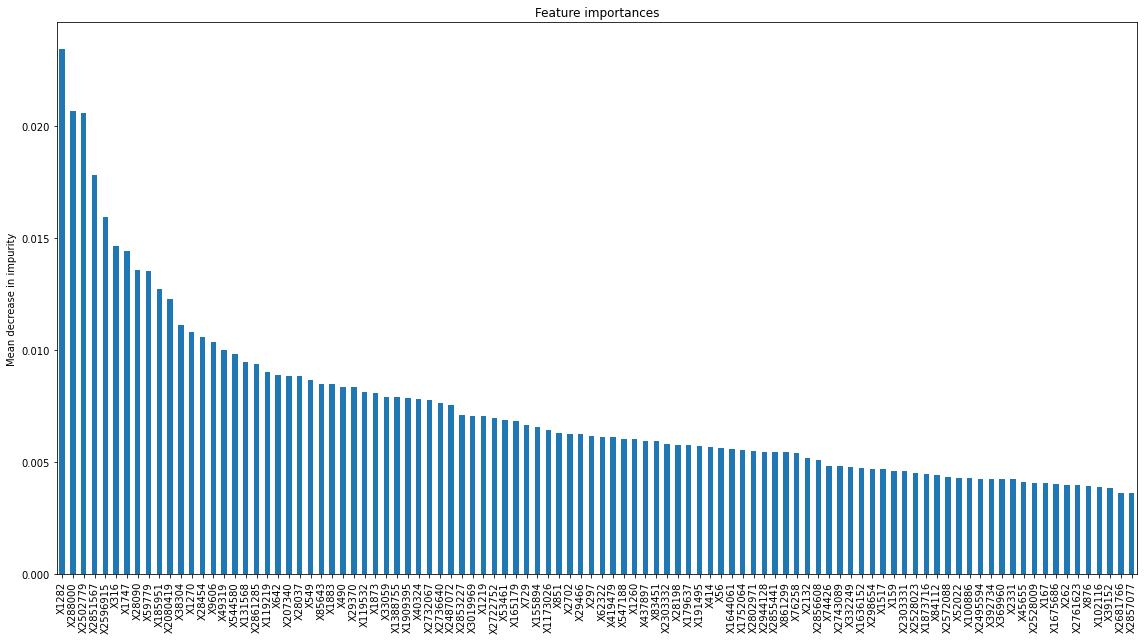

In [59]:
forest_importances = pd.Series(rf_vars)

fig, ax = plt.subplots(figsize=(16,9))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [60]:
reduced_otus_rf = get_reduced_df(otus,varnames,rf_vars)
#reduced_otus_rf
#print(*reduced_otus_rf.columns)

In [61]:
ff = os.path.join(ruta_actual, carpeta_data, 'reduced_otus_rf100.csv')
reduced_otus_rf.to_csv(ff)

## Recursive feature elimination

In [62]:
rfe_vars = rfe_features(X_train, y_train, num_features=n_feat)

reduced_otus_rfe = get_reduced_df(otus,varnames,rfe_vars)
#print(*reduced_otus_rf.columns)

In [63]:
ff = os.path.join(ruta_actual, carpeta_data, 'reduced_otus_RFE100.csv')
reduced_otus_rfe.to_csv(ff)

In [64]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider
svc = SVC(kernel="linear", C=1)
#clf = LogisticRegression()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=cv,
    scoring="f1_weighted",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=SVC(C=1, kernel='linear'), n_jobs=-1, scoring='f1_weighted')

In [65]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 24


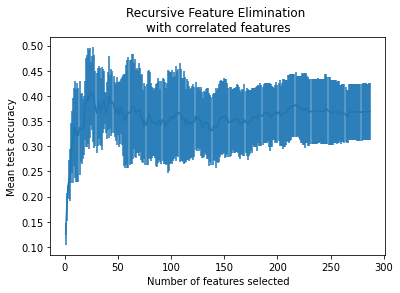

In [66]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [67]:
rfecv_indices = rfecv.get_support(indices=True)
rfecv_indices

array([  2,   6,  11,  20,  22,  31,  34,  36,  50,  53,  58,  59,  60,
        61,  62,  69,  83, 141, 145, 148, 175, 194, 229, 243])

In [68]:
varnames = X_train.columns.tolist()
rfecv_indices = rfecv.get_support(indices=True)
fnames = [varnames[i] for i in rfecv_indices]
rfecv_importances = pd.Series(rfecv.ranking_[rfecv_indices], index=fnames)

In [69]:
reduced_otus_rfecv = get_reduced_df(otus,varnames,rfecv_importances)
reduced_otus_rfecv

,ID_city,City,Year,Latitude,Longitude,Climate,X316,X185951,X1747,X9606,...,X2851567,X2722752,X2502779,X1884905,X1282,X1555112,X651822,X84112,X1632019,X167964
ID,,,,,,,,,,,,,,,,,,,,,
CAMDA23_MetaSUB_gCSD16_AKL_1,AKL,Auckland,16,-36.75,174.75,Cfb,0.000831,0.004533,0.000000,0.003777,...,0.000000,0.000000,0.000000,0.000000,0.447987,0.0,0.000000,0.000000,0.0,0.000000
CAMDA23_MetaSUB_gCSD16_AKL_10,AKL,Auckland,16,-36.75,174.75,Cfb,0.002392,0.070096,0.000363,0.000999,...,0.000000,0.000030,0.000151,0.000000,0.306062,0.0,0.000000,0.000000,0.0,0.000000
CAMDA23_MetaSUB_gCSD16_AKL_11,AKL,Auckland,16,-36.75,174.75,Cfb,0.006530,0.007858,0.003431,0.000996,...,0.000332,0.000111,0.000553,0.000000,0.010847,0.0,0.000000,0.000000,0.0,0.000000
CAMDA23_MetaSUB_gCSD16_AKL_12,AKL,Auckland,16,-36.75,174.75,Cfb,0.027450,0.187237,0.015796,0.124754,...,0.003159,0.000702,0.000983,0.000211,0.061570,0.0,0.000211,0.000281,0.0,0.000140
CAMDA23_MetaSUB_gCSD16_AKL_13,AKL,Auckland,16,-36.75,174.75,Cfb,0.001430,0.003971,0.000635,0.001271,...,0.000000,0.000000,0.000000,0.000000,0.001112,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMDA23_MetaSUB_gCSD17_ZRH_5,ZRH,Zurich,17,47.25,8.75,Cfb,0.005374,0.064229,0.058985,0.032311,...,0.002736,0.000737,0.006751,0.000016,0.002671,0.0,0.000033,0.000049,0.0,0.000016
CAMDA23_MetaSUB_gCSD17_ZRH_6,ZRH,Zurich,17,47.25,8.75,Cfb,0.033446,0.027874,0.129037,0.026909,...,0.017758,0.000965,0.000093,0.000000,0.000903,0.0,0.000016,0.000062,0.0,0.000016
CAMDA23_MetaSUB_gCSD17_ZRH_7,ZRH,Zurich,17,47.25,8.75,Cfb,0.011508,0.007400,0.092820,0.028302,...,0.001631,0.000060,0.000211,0.000060,0.001118,0.0,0.000030,0.000030,0.0,0.000000


In [70]:
ff = os.path.join(ruta_actual, carpeta_data, 'reduced_otus_RFECV.csv')
reduced_otus_rfecv.to_csv(ff)